In [1]:
import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
from sklearn.model_selection import StratifiedGroupKFold
import random
from tensorflow.keras import layers

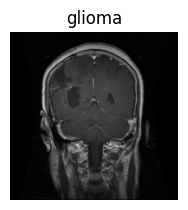

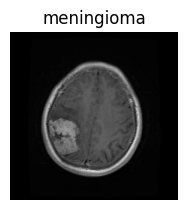

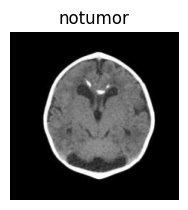

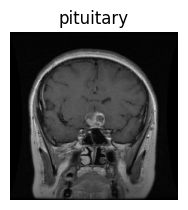

In [2]:
import os
import cv2
import matplotlib.pyplot as plt

# Ensure data_dir ends with a directory separator
data_dir = "C:\\TRAIN\\a2\\Training\\"

# Corrected image filenames
images_path = [
    "glioma\\Tr-gl_0010.jpg",
    "meningioma\\Tr-me_0010.jpg",
    "notumor\\Tr-no_0010.jpg",
    "pituitary\\Tr-pi_0010.jpg"
]

categories = ["glioma", "meningioma", "notumor", "pituitary"]

for i in range(len(images_path)):
    ax = plt.subplot(2, 2, i + 1)
    
    # Read image
    img_path = os.path.join(data_dir, images_path[i])  # Using os.path.join to create correct path
    img = cv2.imread(img_path)
    
    # Check if image is valid
    if img is None:
        print(f"Error: Unable to read image {img_path}")
        continue  # Skip to the next iteration
    
    # Resize image
    img = cv2.resize(img, (224, 224))
    
    # Display image
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
    plt.title(categories[i])
    plt.axis('off')  # Turn off axis
    plt.show()


In [3]:
def crop_img(img):
    """
	Finds the exterior points on the image and crops to that limit
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3,3),0)
    
    #Threshold the image + erode and increase size for better image
    
    thresh = cv2.threshold(gray,45,255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations = 2)
    thresh = cv2.dilate(thresh, None, iterations =2)
    
    #Find the biggest contour(curve that is a whole) and present that as the image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)
    
    #Finding the exterior points
    
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBottom = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0
    new_img = img[extTop[1]-ADD_PIXELS:extBottom[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    
    return new_img



In [4]:
img = cv2.imread("C:\\TRAIN\\a2\\Training\\meningioma\\Tr-meTr_0000.jpg")
img = cv2.resize(
            img,
            dsize = (224,224),
            interpolation = cv2.INTER_CUBIC)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (3,3),0)
    
#Threshold the image + erode and increase size for better image
    
thresh = cv2.threshold(gray,45,255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations = 2)
thresh = cv2.dilate(thresh, None, iterations =2)
    
#Find the biggest contour(curve that is a whole) and present that as the image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key = cv2.contourArea)
    
#Finding the exterior points
    
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBottom = tuple(c[c[:, :, 1].argmax()][0])

#Inputting the contour
img_cnt = cv2.drawContours(img.copy(), [c], -1,(0,255,255),4)

# Add exterior points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0,0,255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0,0,255), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255,0,0), -1)
img_pnt = cv2.circle(img_pnt, extBottom, 8, (255,255,0), -1)

#Crop it
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBottom[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

# Data Augmentation

Text(0.5, 1.0, 'Enlarged Image')

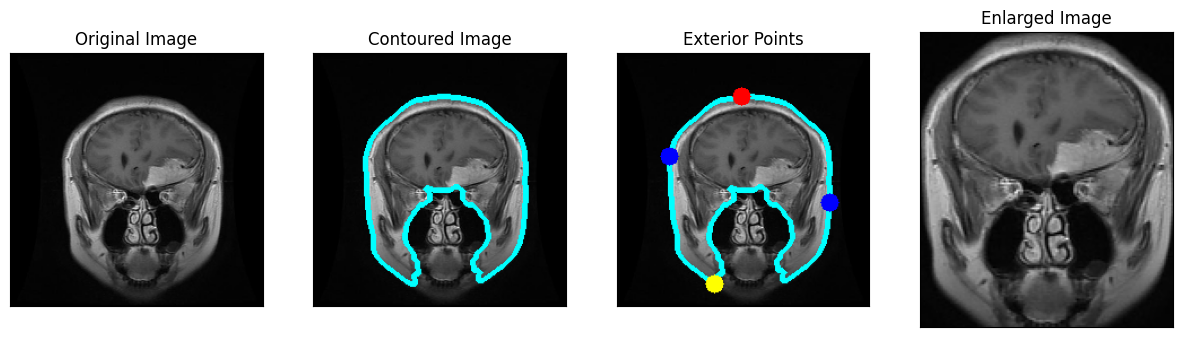

In [5]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Contoured Image')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Exterior Points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Enlarged Image')

In [6]:
if __name__== '__main__':
    testing = 'C:\\TRAIN\\a2\\Testing'
    training = 'C:\\TRAIN\\a2\\Training'
    training_dir = os.listdir(training)
    testing_dir = os.listdir(testing)
    IMG_SIZE = 224
    
    ##Writing images for the training set
    
    for dir in training_dir:
        save_path = 'brain_tumor/cropped_IN/Training/' + dir
        path = os.path.join(training,dir)
        image_dir = os.listdir(path)
        for img in image_dir:
            image = cv2.imread(os.path.join(path,img))
            new_img = crop_img(image)
            new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            cv2.imwrite(save_path+'/'+img, new_img)
    
    ## Writing images to the testing set
    for dir in testing_dir:
        save_path = 'brain_tumour/cropped_IN/Testing/'+ dir
        path = os.path.join(testing,dir)
        image_dir = os.listdir(path)
        for img in image_dir:
            image = cv2.imread(os.path.join(path,img))
            new_img = crop_img(image)
            new_img = cv2.resize(new_img,(IMG_SIZE,IMG_SIZE))
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            cv2.imwrite(save_path+'/'+img, new_img)
    

In [7]:
import os
import cv2
from tqdm import tqdm

labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = []  # Image training
y_train = []  # Label training
x_test = []   # Image testing
y_test = []   # Label testing

image_size = 224

for label in labels:
    trainPath = os.path.join('C:\\TRAIN\\a2\\Training', label.lower())  # Convert label to lowercase
    if not os.path.exists(trainPath):
        print(f"Error: Directory {trainPath} not found.")
        continue
    
    for file in tqdm(os.listdir(trainPath)):
        image_path = os.path.join(trainPath, file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        
        # Check if image is valid
        if image is None:
            print(f"Error: Unable to read image {image_path}")
            continue
        
        # Image preprocessing
        image = cv2.bilateralFilter(image, 2, 50, 50)  # Removes image noise
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)  # Colored Image
        image = cv2.resize(image, (image_size, image_size))  # Resize the image
        x_train.append(image)
        y_train.append(labels.index(label))
        
    testPath = os.path.join('C:\\TRAIN\\a2\\Testing', label.lower())  # Convert label to lowercase
    if not os.path.exists(testPath):
        print(f"Error: Directory {testPath} not found.")
        continue
    
    for file in tqdm(os.listdir(testPath)):
        image_path = os.path.join(testPath, file)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        
        # Check if image is valid
        if image is None:
            print(f"Error: Unable to read image {image_path}")
            continue
        
        # Image preprocessing
        image = cv2.bilateralFilter(image, 2, 50, 50)  # Removes image noise
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)  # Colored Image
        image = cv2.resize(image, (image_size, image_size))  # Resize the image
        x_test.append(image)
        y_test.append(labels.index(label))


100%|██████████| 300/300 [00:00<00:00, 538.17it/s]


In [8]:
x_train = np.array(x_train) / 255.0  #Creates an image array for normalization
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)

(5804, 224, 224, 3)
(1311, 224, 224, 3)


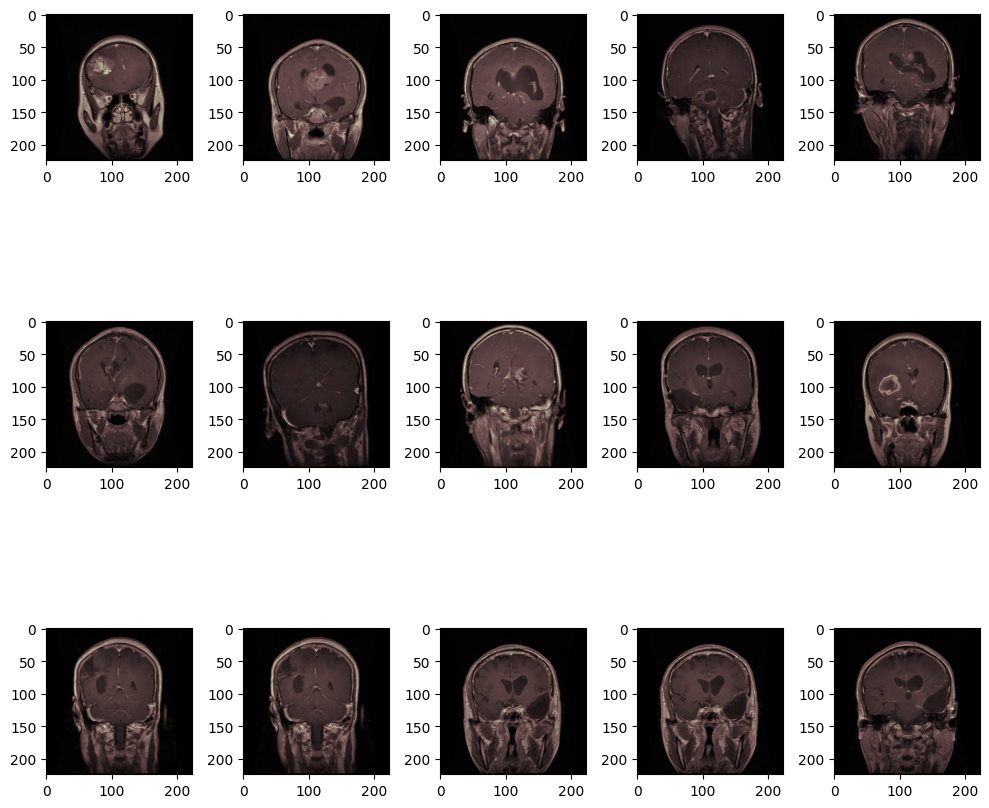

In [10]:
images = [x_train[i] for i in range(15)]
fig , axes = plt.subplots(3,5, figsize = (10,10))
axes = axes.flatten()
for img, ax in zip(images,axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [11]:
x_train, y_train = shuffle(x_train,y_train, random_state=42)

y_train = tensorflow.keras.utils.to_categorical(y_train)
y_test = tensorflow.keras.utils.to_categorical(y_test)

x_train, x_val , y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

print(x_val.shape)

(1161, 224, 224, 3)


# Flipping the images (demo)
# for proper augmentation, changing the image parameters
# Below is the framework of how it would work

In [13]:
demo_datagen = ImageDataGenerator(
     rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)


os.mkdir('preview_99')
x = x_train[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview_99', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

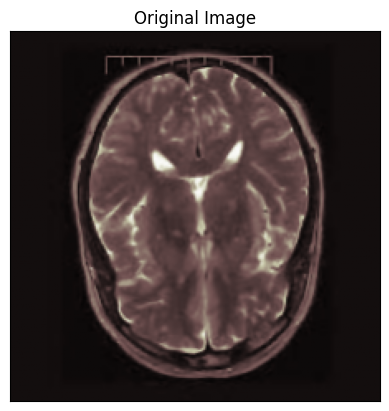

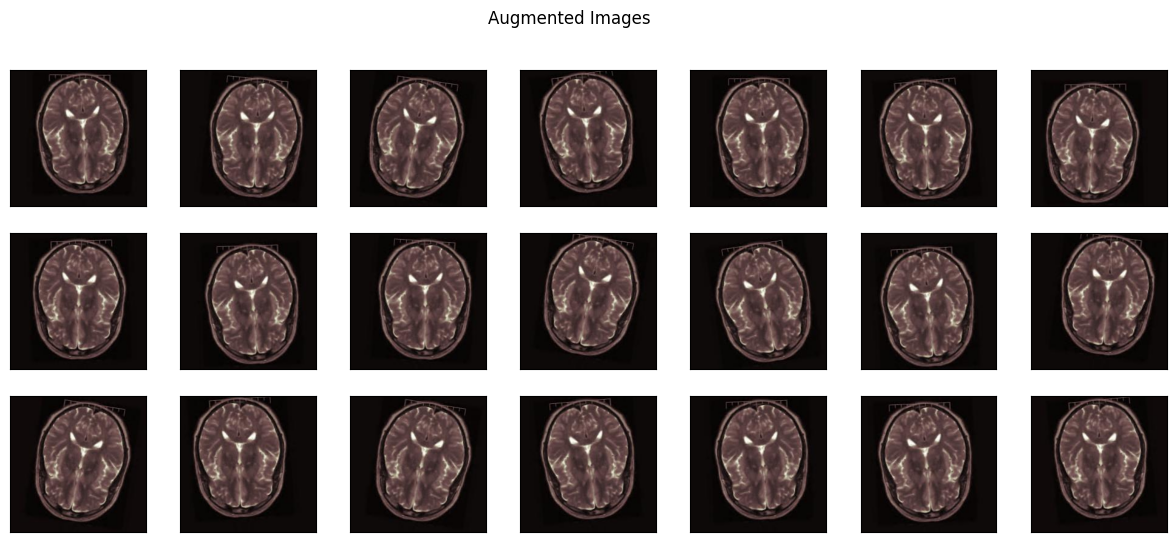

In [14]:
import matplotlib.pyplot as plt
import cv2
import os

# Display the original image
plt.imshow(x[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

# Display augmented images
plt.figure(figsize=(15, 6))
i = 1
for img_name in os.listdir('preview_99/'):
    if i > 3 * 7:  # Limiting to display 21 images (3 rows, 7 columns)
        break
    img_path = os.path.join('preview_99/', img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(3, 7, i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])  
    i += 1

plt.suptitle('Augmented Images')
plt.show()


# Actual Flipping of the images

In [15]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    zoom_range=0.2,
    shear_range=0.05,
    horizontal_flip=True,
    vertical_flip=True
)
os.mkdir('preview_90')
x = x_train[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in datagen.flow(x, batch_size=1, save_to_dir='preview_90', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

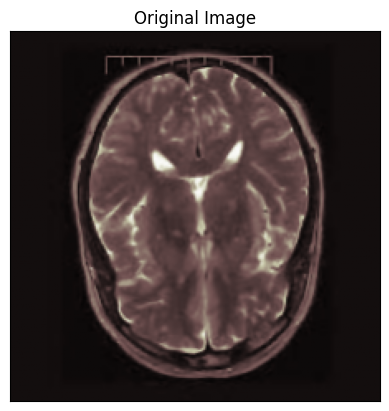

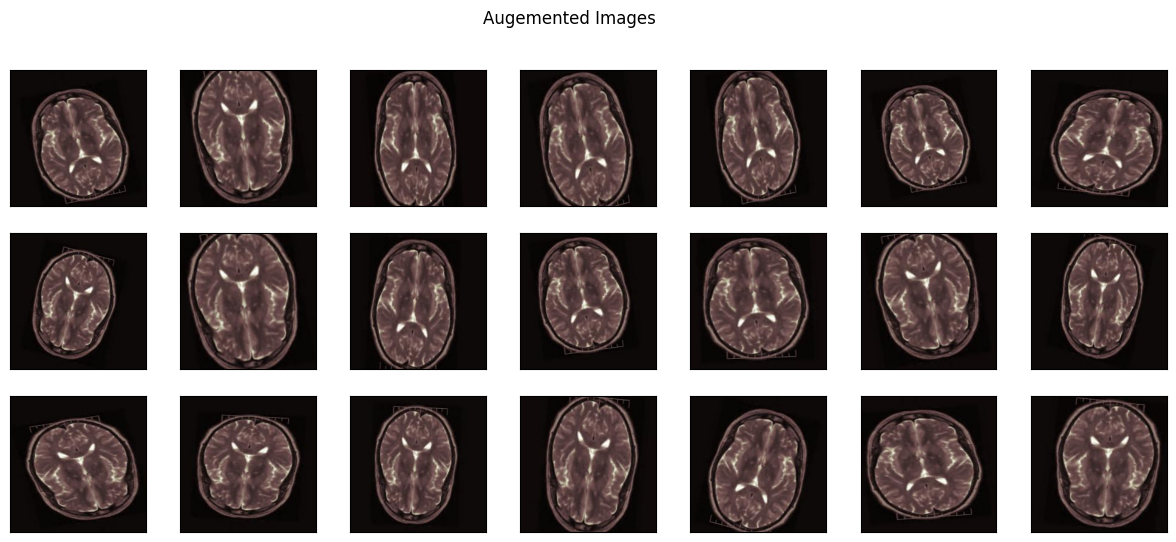

In [16]:
plt.imshow(x[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview_90/'):
    img = cv2.imread('preview_90/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [17]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

IMG_SIZE = (224, 224)  # Adjusted input size for InceptionV3

# Load InceptionV3 without top layer
conv_base = InceptionV3(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights='imagenet'
)

# Set layers in InceptionV3 as trainable
for layer in conv_base.layers:
    layer.trainable = True

# Add custom classifier on top of InceptionV3
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(4, activation="softmax")(x)

# Define the model
model = Model(inputs=conv_base.input, outputs=predictions)

# Compile the model
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,810,980 (83.20 MB)

 Trainable params: 21,776,548 (83.07 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [19]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint('.mdl_wtsIN2.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.0000000)
]


In [20]:
train_len  = len(x_train)
val_len = len(x_val)
print("--------Training Data Length--------")
print(train_len)

print("--------Validation Data Length--------")
print(val_len)

--------Training Data Length--------
4643
--------Validation Data Length--------
1161


In [21]:
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),validation_data = (x_val,y_val),epochs = 8,callbacks = callbacks) 

Epoch 1/8


C:\Users\sujal\anaconda3\envs\gpu\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7425 - loss: 0.6749
Epoch 1: val_loss improved from inf to 1.28652, saving model to .mdl_wtsIN2.keras
146/146 ━━━━━━━━━━━━━━━━━━━━ 251s 2s/step - accuracy: 0.7432 - loss: 0.6731 - val_accuracy: 0.6322 - val_loss: 1.2865 - learning_rate: 1.0000e-04
Epoch 2/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9470 - loss: 0.1583
Epoch 2: val_loss did not improve from 1.28652
146/146 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.9470 - loss: 0.1583 - val_accuracy: 0.1972 - val_loss: 7.7781 - learning_rate: 1.0000e-04
Epoch 3/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9627 - loss: 0.1114
Epoch 3: val_loss did not improve from 1.28652

Epoch 3: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
146/146 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.9627 - loss: 0.1114 - val_accuracy: 0.2541 - val_loss: 47.9616 - learning_rate: 1.0000e-04
Epoch 4/8
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9

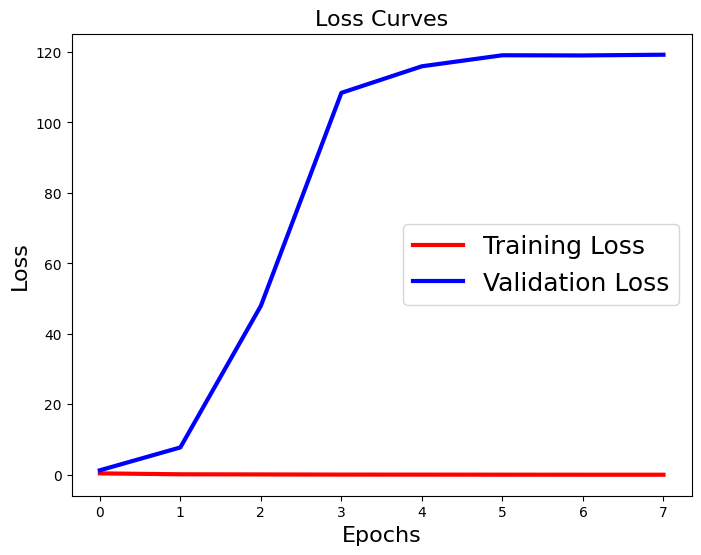

In [22]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'], 'r', linewidth = 3.0)
plt.plot(history.history['val_loss'],'b', linewidth = 3.0)
plt.legend(['Training Loss', 'Validation Loss'], fontsize= 18)
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)
plt.title('Loss Curves', fontsize = 16)
plt.show()

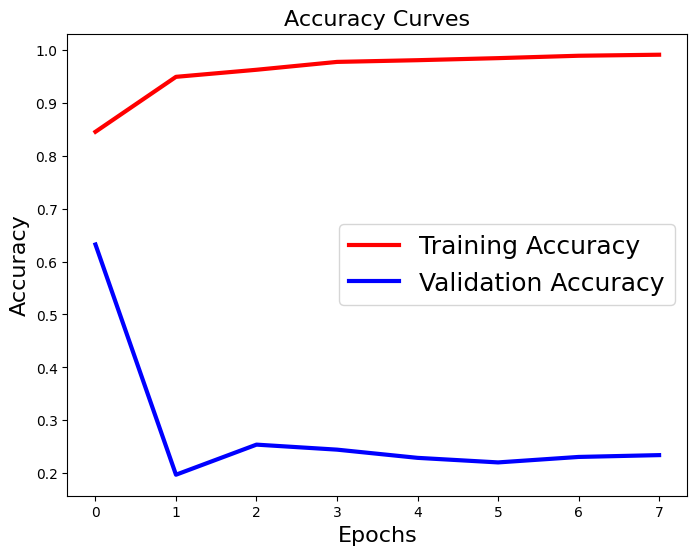

In [23]:
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'], 'r', linewidth = 3.0)
plt.plot(history.history['val_accuracy'],'b', linewidth = 3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize= 18)
plt.xlabel('Epochs', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.title('Accuracy Curves', fontsize = 16)
plt.show()


In [24]:
from tensorflow.keras.models import load_model

model = load_model('.mdl_wts.keras')
model.save(r'C:\Users\sujal\projects\BIO3\BT_IN.keras')

model = load_model(r'C:\Users\sujal\projects\BIO3\BT_IN.keras')

164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step


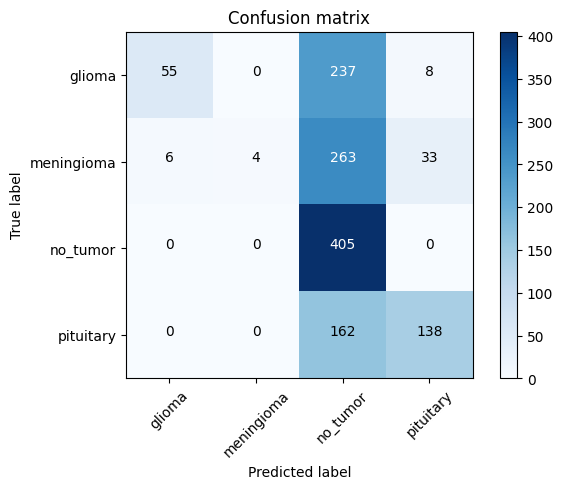

In [28]:
import itertools
pred_Y = model.predict(x_test, batch_size = 8, verbose = True)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    target_names=['glioma','meningioma','no_tumor','pituitary']

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_test, batch_size=8)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(pred_Y,axis = 1) 
# Convert validation observations to one hot vectors
# compute the confusion matrix
rounded_labels=np.argmax(y_test, axis=1)
confusion_mtx = confusion_matrix(rounded_labels, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(4))

In [27]:
import cv2

# Resize images in x_test to match the expected input shape
resized_x_test = np.array([cv2.resize(img, (200, 200)) for img in x_test])

# Make predictions on resized test data
predicted_classes = np.argmax(model.predict(resized_x_test), axis=1)

# Print classification report
print(classification_report(
    np.argmax(y_test, axis=1), 
    predicted_classes, 
    target_names=['glioma', 'meningioma', 'no_tumor', 'pituitary']
))


41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 162ms/step
              precision    recall  f1-score   support

      glioma       0.84      0.25      0.39       300
  meningioma       1.00      0.02      0.04       306
    no_tumor       0.40      0.99      0.57       405
   pituitary       0.71      0.51      0.59       300

    accuracy                           0.49      1311
   macro avg       0.74      0.44      0.40      1311
weighted avg       0.71      0.49      0.41      1311



# More images tend to increase error
# ->Can be deviated with INCREASED EPOCHS
# ->orange dictates a mismatch

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step


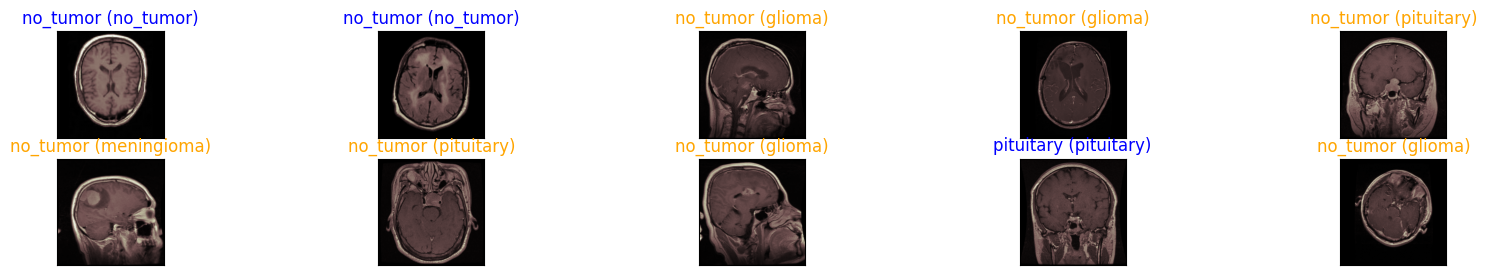

In [31]:
y_hat = model.predict(x_test)

# define text labels 
target_labels = ['glioma','meningioma','no_tumor','pituitary']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=10, replace=False)):
    ax = fig.add_subplot(5,5, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step


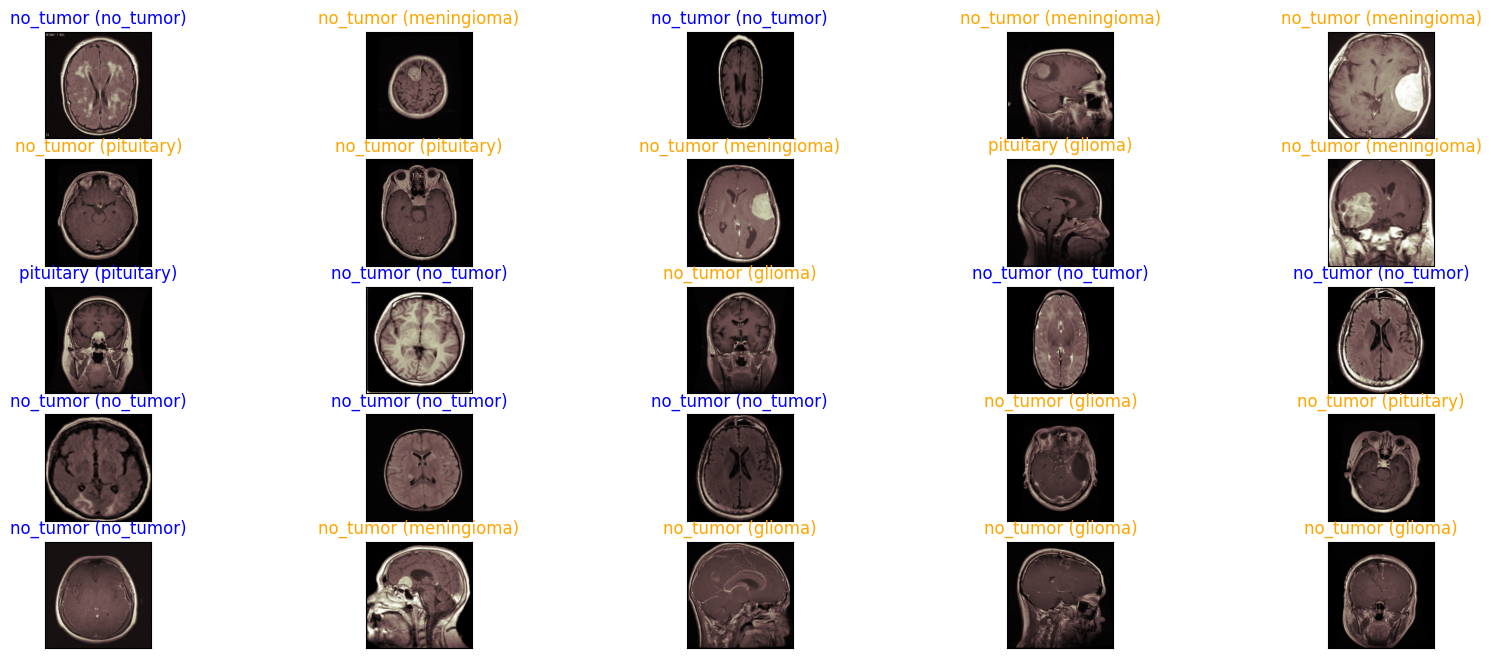

In [32]:
y_hat = model.predict(x_test)

# define text labels 
target_labels = ['glioma','meningioma','no_tumor','pituitary']

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=25, replace=False)):
    ax = fig.add_subplot(5,5, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_hat[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("blue" if pred_idx == true_idx else "orange"))